# Imports

In [81]:

import quimb.tensor as qtn
import qiskit as qk
import numpy as np
from hamiltonian import model_mpo
import basic_circuits as circuits
from quimb.tensor.optimize_autograd import TNOptimizer

# Thermal state functions

In [94]:

def prob_list(circuit,params,T):
    """ 
    Returns list of probability weights.
    """
    d = circuit[0,:,0,0].size
    prob_params = params[:d]
    if T != 0:
        exc_list= np.array([np.exp(-k/T) for k in prob_params])
        z = sum(exc_list)
        prob_list = exc_list/z         
    else:
        prob_list = np.zeros(d)
        # setting probability of |0> to 1 at T = 0
        prob_list[0] += 1
    return prob_list

def MPDO(circuit,params,Hamiltonian,T,n,j):
    """
    Constructs the Matrix Product Density Operator
    """
    inds1 = f'p{j}', f'b{n+1}',f'p{j+1}',f'b{n}'
    k = qtn.Tensor(circuit, inds1, tags='k')
    
    data = np.diag(prob_list(circuit,params,T))
    inds2 = f'p{j+1}',f'p{j+2}'
    p_chain = qtn.Tensor(data,inds2,tags='p')

    inds3 = f'p{j+3}',f'bc{n+1}',f'p{j+2}',f'bc{n}'
    b = qtn.Tensor(circuit.conj(), inds3, tags= 'kc')

    inds4 = f'p{j}',f'H{n+1}',f'p{j+3}',f'H{n}'
    H = qtn.Tensor(Hamiltonian,inds4,tags='H')
    
    TN = k & p_chain & b & H 
    return TN

def contractions(unit_list,params,
                 Hamiltonian,L,
                 state_vcl,state_vcr,
                 H_bvecl,H_bvecr,T):
    """
    Returns tensor contractions
    """
    unit_list1 = L * unit_list
    params1 = L * params
    N = L * len(unit_list)
    TN_list = [MPDO(unit_list1[n],params1[n],Hamiltonian,T,n,j) for n,j in zip(range(N),range(0,4*N+6,5))]

    # boundary conditions
    # for ket:
    inds0 = 'b0',
    s_left = qtn.Tensor(state_vcl,inds0,tags='sl')
    inds1 = f'b{N}',f'bc{N}'
    s_right = qtn.Tensor(np.eye(state_vcl.size),inds1,tags='rvec')

    # for bra:
    inds2 = 'bc0',
    sc_left = qtn.Tensor(state_vcl.conj(),inds2,tags='scl')

    # for Hamiltonian
    inds4 = 'H0',
    H_left = qtn.Tensor(H_bvecl,inds4,tags='Hl')  
    inds5 = f'H{N}',
    H_right = qtn.Tensor(H_bvecr,inds5,tags='Hr') 

    # tenor contractions
    TN0 = TN_list[0]
    for j in range(1,len(TN_list)):
        TN0 = TN_list[j] & TN0
    
    TN = s_left & s_right & sc_left & H_left & H_right & TN0
    return TN

def entropy(prob_list):
    """
    Returns the entropy
    """ 
    # avoiding NaN in numpy.log() function
    new_prob_list = []
    for j in prob_list:
        if np.array(j) > 1.e-30:
            new_prob_list.append(j)
    s_list = [-p*np.log(p) for p in new_prob_list]
    s = sum(s_list) # entropy
    return s

def free_energy(unit_list,params,
                Hamiltonian,L,
                state_vcl,state_vcr,
                H_bvecl,H_bvecr,T):
    """
    Free energy function
    """
    TN = contractions(unit_list,params,Hamiltonian,L,state_vcl,state_vcr,H_bvecl,H_bvecr,T)
    l_uc = len(unit_list)
    E = TN.contract(all, optimize='auto-hq')
    p_list = [prob_list(unit_list[j],params[j],T) for j in range(l_uc)]
    s_list = [entropy(p) for p in p_list]
    F = E - T*sum(s_list)/l_uc
    return F

# Example for self-dual Ising model

In [95]:

# circuit structure
def circuit(nb,params):
    backend = qk.Aer.get_backend('unitary_simulator')
    c = qk.QuantumCircuit(nb+1)
    circuits.add_su4_circ(c, 0, 1, params[:15]) 
    if nb ==2:
        circuits.add_su4_circ(c, 0, 2, params[15:]) 
    job = qk.execute(c, backend)
    result = job.result()
    #get the unitary matrix from the result object
    return result.get_unitary(c, decimals=8)


In [96]:

# params
T = 0
nb = 1
l_uc = 1
L = 5
N = L * l_uc
J = 1
V = 1
h = 0

In [97]:

# state and bdry vecs
state_vcl = np.array([1,0])
state_vcr = np.array([1,0])
Hamiltonian = model_mpo.sd_ising(J,V,h,N)
chi_H = Hamiltonian[0,:,0,0].size # size of Hamiltonian bond leg dimension
H_bvecr = [1,0,0,0,0]
H_bvecl = np.zeros(chi_H)
H_bvecl[-1] = 1
bdry_vecs2 = [H_bvecl,H_bvecr]

free energy = -0.7390160147782444, T = 0


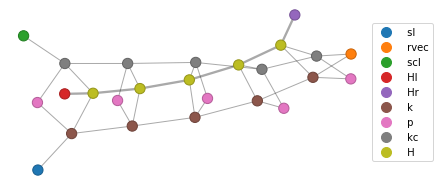

In [100]:

"""Hi Yuxuan, for this method, we contract the right boundary vecs as shown in Drew's note"""

rng = np.random.default_rng()
x0 = [rng.uniform(high=2*np.pi,size = nb*15 + 2)]
unit_list = [circuit(1,x0[0]).reshape(2,2,2,2)]
free = free_energy(unit_list,x0,
                Hamiltonian,L,
                state_vcl,state_vcr,
                H_bvecl,H_bvecr,T)
TN = contractions(unit_list,x0,Hamiltonian,L,state_vcl,state_vcr,H_bvecl,H_bvecr,T)
print(f'free energy = {free}, T = {T}')
TN.graph(color=['sl','rvec','scl','Hl','Hr','k','p','kc','H'])

In [87]:

""" Could you please get the following lines working? Thx!"""
TN = contractions(unit_list,x0,Hamiltonian,L,state_vcl,state_vcr,H_bvecl,H_bvecr,T)
tnopt = TNOptimizer(TN,free,optimizer='L-BFGS-B')

TypeError: the first argument must be callable

# Second method

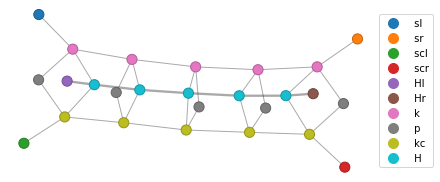

In [88]:

""" For this method, we should also define the right boundary vecs"""
def contractions(unit_list,params,
                 Hamiltonian,L,
                 state_vcl,state_vcr,
                 H_bvecl,H_bvecr,T):
    """
    Returns tensor contractions
    """
    unit_list1 = L * unit_list
    params1 = L * params
    N = L * len(unit_list)
    TN_list = [MPDO(unit_list1[n],params1[n],Hamiltonian,T,n,j) for n,j in zip(range(N),range(0,4*N+6,5))]

    # boundary conditions
    # for ket:
    inds0 = 'b0',
    s_left = qtn.Tensor(state_vcl,inds0,tags='sl')
    inds1 = f'b{N}',
    s_right = qtn.Tensor(state_vcr,inds1,tags='sr')

    # for bra:
    inds2 = 'bc0',
    sc_left = qtn.Tensor(state_vcl.conj(),inds2,tags='scl')
    inds3 = f'bc{N}',
    sc_right = qtn.Tensor(state_vcr.conj(),inds3,tags='scr')

    # for Hamiltonian
    inds4 = 'H0',
    H_left = qtn.Tensor(H_bvecl,inds4,tags='Hl')  
    inds5 = f'H{N}',
    H_right = qtn.Tensor(H_bvecr,inds5,tags='Hr') 

    # tenor contractions
    TN0 = TN_list[0]
    for j in range(1,len(TN_list)):
        TN0 = TN_list[j] & TN0
    
    TN = s_left & s_right & sc_left & sc_right & H_left & H_right & TN0
    return TN

TN = contractions(unit_list,x0,Hamiltonian,L,state_vcl,state_vcr,H_bvecl,H_bvecr,T)
TN.graph(color=['sl','sr','scl','scr','Hl','Hr','k','p','kc','H'])